Note: This script is to suplement `gan_generate_wforms.ipynb` and run atop its kernal to visualize the results. 

In [252]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family']      = 'STIXGeneral'
def set_plot_format(fmtkey = 'default'):
    if isinstance(fmtkey, tuple):
        matplotlib.rcParams.update({'font.size': fmtkey[0]})
        matplotlib.rc('xtick', labelsize=fmtkey[1])
        matplotlib.rc('ytick', labelsize=fmtkey[2])         
    elif fmtkey == 'default':
        matplotlib.rcParams.update({'font.size': 15})
        matplotlib.rc('xtick', labelsize=12)
        matplotlib.rc('ytick', labelsize=12) 
    elif fmtkey == '1by2':
        matplotlib.rcParams.update({'font.size': 30})
        matplotlib.rc('xtick', labelsize=24)
        matplotlib.rc('ytick', labelsize=24) 

In [253]:
import scipy
from copy      import deepcopy
from itertools import product
from functools import reduce

In [254]:
TRAINING = False
print(project_dir)

GAN_2019-05-09-B


In [255]:
def bins_idx(bins: tuple, cond_idxs = gm.cond_idxs):
    
    idxs = [np.where(np.array(cond_idxs[i]) == b)[0] for i, b in enumerate(bins)]
        
    idxs = reduce(lambda i1, i2: np.intersect1d(i1, i2), idxs)
                       
    return list(idxs)

def format_dist_bin(b):
    return 'R{:.0f} - {:.0f}km'.format(*dist_bins[b])
 
def format_magn_bin(b):
    return 'M{:.1f} - {:.1f}'  .format(*magn_bins[b])

def format_bins(bins):
    return '  / '.join([
        fmt_func_d[meta_names[i]](b)
        for i, b in enumerate(bins)
    ])
    
fmt_func_d = {
    'magn' : format_magn_bin,
    'dist' : format_dist_bin
}

In [256]:
#-------------------
# Bins to visualize.
#-------------------

meta_names        = gm.config['metas']
bins_ss           = [[(0, 1), (0, 4), (0, 6)], [(4, 4), (4, 6)], [(7, 4), (7, 6)]]
bins_ss           = [[(0, 1), (0, 4), (0, 6)], [(3, 1), (3, 4), (3, 6)], [(7, 4), (7, 6)]]

bins_ss_flat      = [bins for bins_s in bins_ss for bins in bins_s]
bins_list         = [bins_ss_flat[0], bins_ss_flat[3], bins_ss_flat[5]]

# Define list of all bins and bin edges (to be used later for possibly non-plotting purposes).
all_bins = list(
    product(
        range(len(gm.bins[0]) - 1), range(len(gm.bins[1]) - 1) # take cartesian product of bin indices
    )
)
bin_edges =  [list(zip(b[0:-1], b[1:])) for b in gm.bins]


#------------------
# Normalization 
#------------------

# Determine whether to plot generated results and normalized or non-normalized data.
if gm.config.get('predict_normalization_factor') is True:
    print('Using un-normalized waveforms from dataset for visualizations')
    normalize = False
else:
    print('Using normalized waveforms from dataset for visualizations')
    normalize = True
    
# Define number of timesteps.
measure_rate = gm.config.get('measure_rate', 20)
n_time_steps = gm.config.get('input_seconds', 20) * measure_rate

print('Using {} timesteps.'.format(n_time_steps))
    
def get_data(indeces, normalize = normalize, input_seconds = None):
    '''
    Helper function to get data given value of 'normalize'.
    '''
    d = gm.SG_train.get_indices(indeces, normalize = normalize, input_seconds = None)
    return d.x

Using un-normalized waveforms from dataset for visualizations
Using 1600 timesteps.


# Example Wform Plot

In [257]:
#-------------------
# Format for plots.
#-------------------
gm_bins = deepcopy(gm.bins)

magn_upper_ranges     = gm_bins[1][1:]
magn_upper_ranges[-1] = 8.5 if magn_upper_ranges[-1] == np.inf else magn_upper_ranges[-1]
magn_lower_ranges     = gm_bins[1][:-1]
magn_bins = list(zip(magn_lower_ranges, magn_upper_ranges))

dist_upper_ranges     = gm_bins[0][1:]
dist_upper_ranges[-1] = 400 if dist_upper_ranges[-1] == np.inf else dist_upper_ranges[-1]
dist_lower_ranges     = gm_bins[0][:-1]
dist_bins = list(zip(dist_lower_ranges, dist_upper_ranges))

pred_meta_values = list(map(lambda bins: format_bins(bins), bins_list))
print(pred_meta_values)

['R4 - 44km  / M4.0 - 4.5', 'R123 - 162km  / M4.0 - 4.5', 'R123 - 162km  / M7.0 - 8.5']


In [258]:
# Define function to generate waveforms by a specified conditional bin.
def gen_wforms(bins_list = [], bins = None, N = 1):
               
    assert not (bins_list and bins), "Must specifiy a list of bins or one i.e. [(0, 0), (0, 1)] or (0, 1)"
               
    bins_list = bins_list * N or [bins] * N
               
    conditional = []
    for i, b in enumerate(zip(*bins_list)):
        c_i                   = np.zeros((len(b), len(gm.bins[i]) - 1))
        c_i[range(len(b)), b] = 1
        conditional.append(c_i)
    # print('conditional\n', conditional)

    predgen = gm.generator(gm.latent(len(bins_list)), training = TRAINING, conditional = conditional, bnorm_training = False)
    
    return predgen


In [259]:
conditional[0].shape, conditional[1].shape, list(zip(*bins_list))

((256, 10), (256, 7), [(0, 3, 3), (1, 1, 6)])

In [260]:
#---------------------
# Prep real wforms
#---------------------

print('Creating sample output for bins:')
print('   ', pred_meta_values)
print()

test_wforms_idxs = [np.random.choice(bins_idx(bins)) for bins in bins_list]
test_wforms      = np.concatenate([get_data([idx])[:, 0:n_time_steps, :] for idx in test_wforms_idxs], 0)
test_meta_values = ['R{:.0f}'.format(gm.data.metad['dist'][idx]) + ' / ' + 'M{:.0f}'.format(gm.data.metad['magn'][idx]) for idx in test_wforms_idxs]


for i, idx in enumerate(test_wforms_idxs):
    print('test wforms |{}|: {}'.format(idx, test_meta_values[i]))

#---------------------
# Prep conditional.
#---------------------
    
# conditional = []
# for i, b in enumerate(zip(*bins_list)):
#     c_i                   = np.zeros((256, len(gm.bins[i]) - 1))
# #     c_i                   = np.zeros((len(bins_list), len(gm.bins[i]) - 1))
#     c_i[range(len(b)), b] = 1
#     conditional.append(c_i)
# # conditional = np.concatenate(conditional, 1).astype(np.float32)
# print('conditional\n', conditional)

#-----------------------
# Prep generated wforms.
#-----------------------

# predgen = gm.generator(gm.latent(len(bins_list)), training = TRAINING, conditional = conditional, bnorm_training = False)
# predgen = gm.generator(gm.latent(256), training = TRAINING, conditional = conditional, bnorm_training = False)
predgen = gen_wforms(bins_list = bins_list)

# predgen = gm.sess.run(predgen)

#-----------------------------
# Prep stack of real and fake.
#-----------------------------

ex_real = np.zeros((1, n_time_steps, len(bins_list)))
for i in range(len(bins_list)):
    ex_real[..., i] = test_wforms[i, ..., 0]

ex_fake = np.zeros((1, n_time_steps, len(bins_list)))
for i in range(len(bins_list)):
    ex_fake[..., i] = predgen[i, ..., 0]

examples = np.vstack([ex_real, ex_fake])
print('examples.shape', examples.shape)

Creating sample output for bins:
    ['R4 - 44km  / M4.0 - 4.5', 'R123 - 162km  / M4.0 - 4.5', 'R123 - 162km  / M7.0 - 8.5']

test wforms |41775|: R21 / M4
test wforms |119106|: R161 / M4
test wforms |247088|: R125 / M7
examples.shape (2, 1600, 3)


Saving image at global step: 87348


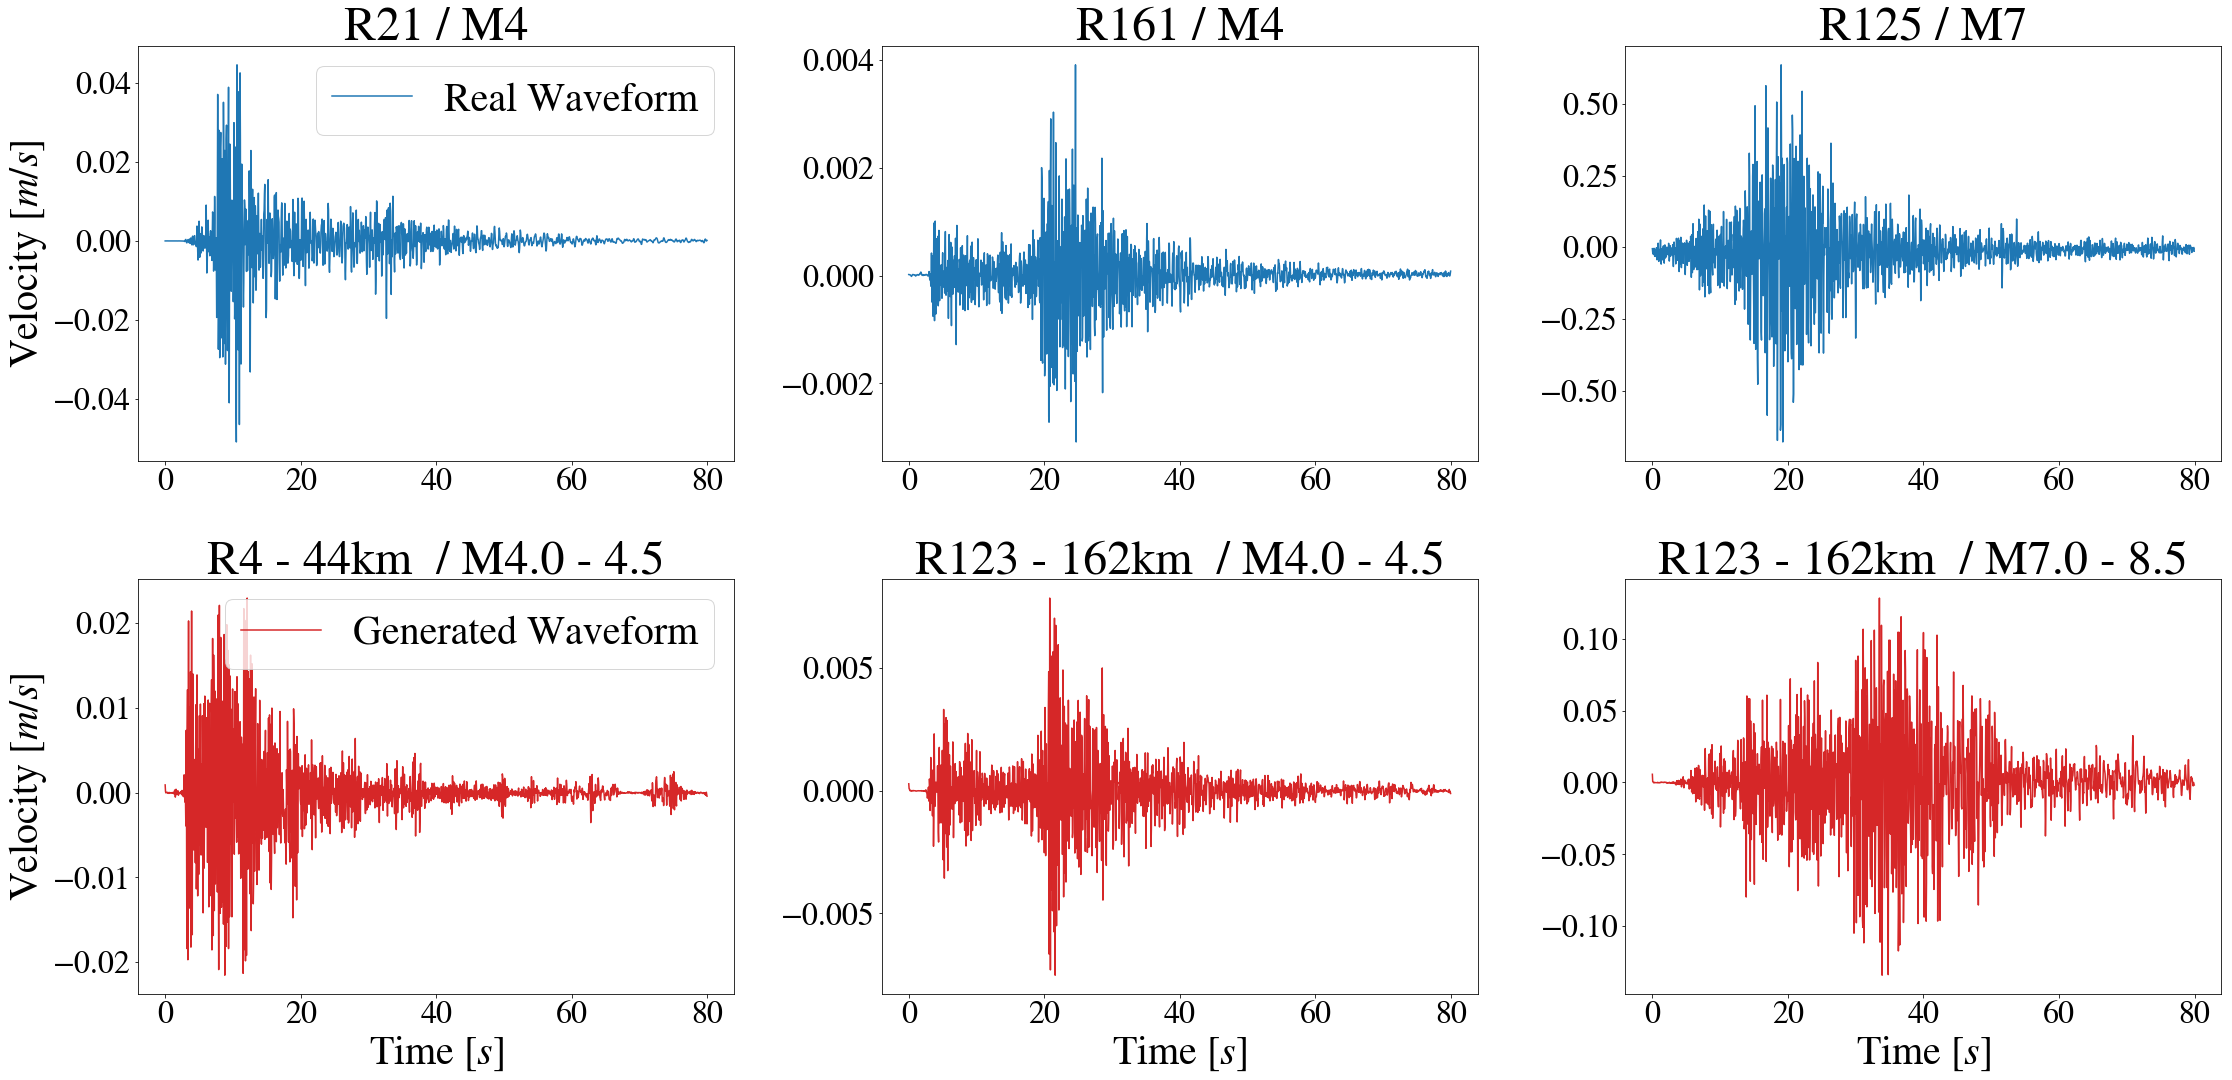

In [263]:
import SeisUtils; reload(SeisUtils); from SeisUtils import plot_wforms
set_plot_format((30, 24, 24)) # For Presentation
set_plot_format((40, 32, 32)) # For nuerips styling
x_values = np.arange(examples.shape[1]) / gm.config.get('measure_rate', 100)
fig, axs = plot_wforms(
    examples, 
    figsize  = (32, 16), 
    x_values = x_values, 
    xlabels  = ['Time [$s$]'] * examples.shape[-1], 
    ylim     = [-1, 1] if normalize else None, 
    ylabels  = ['Velocity [$m/s$]'] * examples.shape[0]
)

# Plot Reals 
for j in range(len(bins_list)):

    axs[0, j].set_title(test_meta_values[j])

    if j == 0:
        axs[0, j].legend(['Real Waveform'], loc = 'upper right')

# Plot Fakes
for j in range(len(bins_list)):

    axs[1, j].set_title(pred_meta_values[j])
    axs[1, j].get_lines()[0].set_c(plt.rcParams['axes.prop_cycle'].by_key()['color'][3])

    if j == 0:
        axs[1, j].legend(['Generated Waveform'], loc = 'upper right')
        
fig.tight_layout() 
global_step = gm.sess.run(gm.global_step)
print('Saving image at global step:', global_step)
fig.savefig(os.path.join(project_dir, '{:08d}_example_wforms.png'.format(global_step)))
if True: fig.savefig(os.path.join(project_dir, '{:08d}_example_wforms.svg'.format(global_step)), format = 'svg')

# Quantile Plot of Wforms

In [179]:
#------------------------------------
# Get samples (real/fake) for bins
#------------------------------------

# Save sample bin for quick access. 
SAMP_BIN_D_NAME = 'samp_bin_d_{}_{}.npy' if normalize is True else 'samp_bin_d_{}_{}_unormalized.npy'

def bin_name(b):
    return ''.join([str(i) for i in b])

def save_samp_bin_d():
    for b, v in samp_bin_d.items():
        b_u = bin_name(b)
        samp_name = SAMP_BIN_D_NAME.format(N, b_u)
        np.save(samp_name, v)

samp_bin_d = {}
gen_bin_d  = {}

N         = 256
samp_bin_d.update({bins : [] for bins in bins_ss_flat if bins not in samp_bin_d or len(samp_bin_d[bins]) != N})
gen_bin_d .update({bins : [] for bins in bins_ss_flat if bins not in gen_bin_d  or len(gen_bin_d [bins]) != N})

for b_i, bins in enumerate(bins_ss_flat):
    
#     conditional = []
#     for i, b_j in enumerate(bins):

#         c_i       = np.zeros((N, len(gm.bins[i]) - 1))
#         c_i[:, b_j] = 1
#         conditional.append(c_i)

    # conditional = np.concatenate(conditional, 1)
    # print('     Feeding conditional:', bins)
    # print('     ', conditional.shape)

    idxs              = bins_idx(bins)
    samples_idx       = np.random.choice(idxs, size = np.min([N, len(idxs)]), replace = False)
    samples_idx.sort()

    if len(samp_bin_d[bins]) != N or samp_bin_d.get('normalized') != normalize:
        
        samp_bin_d['normalized'] = normalize 
        b_u = bin_name(bins)
        samp_bin_d_name = SAMP_BIN_D_NAME.format(N, b_u)
        if os.path.isfile(samp_bin_d_name):
            print('Loading for bin', bins)
            samp_bin_d[bins] = np.load(samp_bin_d_name)
        else:
            print('Sampling for bin', bins)
            samp_bin_d[bins]     = get_data(samples_idx)
    
    if len(gen_bin_d [bins]) != N:
        print('Generating from bin', bins) 
        gen_bin_d [bins]         = gen_wforms(bins = bins, N = N) # gm.generator(gm.latent(N), conditional = conditional, training = TRAINING)

# Save samp_bin_d for later use. 
save_samp_bin_d()

Loading for bin (0, 1)
Generating from bin (0, 1)
Loading for bin (0, 4)
Generating from bin (0, 4)
Loading for bin (0, 6)
Generating from bin (0, 6)
Loading for bin (3, 1)
Generating from bin (3, 1)
Loading for bin (3, 4)
Generating from bin (3, 4)
Loading for bin (3, 6)
Generating from bin (3, 6)
Loading for bin (7, 4)
Generating from bin (7, 4)
Loading for bin (7, 6)
Generating from bin (7, 6)


In [181]:
#----------------------
# Take fft of samples.
#----------------------

fft_wforms = []

samp_fft_d = {}
gen_fft_d  = {}
ks_stats_d = {}

show_ks_stats = False 
print('ks_2samp Statistic for Norm v Norm', stats.ks_2samp(np.random.normal(size = 10000), np.random.normal(size = 10000)))

for b, bins in enumerate(bins_ss_flat):

    samp_fft = np.abs(np.fft.fft(samp_bin_d[bins][:,0:n_time_steps,:], axis = 1))
    gen_fft  = np.abs(np.fft.fft(gen_bin_d [bins][:,0:n_time_steps,:], axis = 1))

    samp_fft_ = samp_fft.transpose((2, 0, 1))
    gen_fft_  = gen_fft .transpose((2, 0, 1))

    samp_fft_ = np.reshape(samp_fft_, (3, samp_fft_.shape[1] * samp_fft_.shape[2]))
    gen_fft_  = np.reshape(gen_fft_ , (3, gen_fft_ .shape[1] * gen_fft_ .shape[2]))
    
    if show_ks_stats: print('Running analyses on', format_bins(bins), '\n')
    for j in range(3):
        if show_ks_stats: print('     KS Statitic for channel {}'.format(j))
        ks_stats_d[bins] = stats.ks_2samp(samp_fft_[j, ...], gen_fft_[j, ...])
        if show_ks_stats: print('     ', ks_stats_d[bins])
    if show_ks_stats: print()
               
    samp_fft_d[bins] = samp_fft
    gen_fft_d [bins] = gen_fft    
print('ks_stats_d:', ks_stats_d)

ks_2samp Statistic for Norm v Norm Ks_2sampResult(statistic=0.010699999999999987, pvalue=0.6138762074051833)
ks_stats_d: {(0, 1): Ks_2sampResult(statistic=0.1843798828125, pvalue=0.0), (0, 4): Ks_2sampResult(statistic=0.17463134765625, pvalue=0.0), (0, 6): Ks_2sampResult(statistic=0.17311279296875, pvalue=0.0), (3, 1): Ks_2sampResult(statistic=0.19911621093749998, pvalue=0.0), (3, 4): Ks_2sampResult(statistic=0.1934619140625, pvalue=0.0), (3, 6): Ks_2sampResult(statistic=0.1735595703125, pvalue=0.0), (7, 4): Ks_2sampResult(statistic=0.20613281249999998, pvalue=0.0), (7, 6): Ks_2sampResult(statistic=0.14743896484375002, pvalue=0.0)}


In [182]:
colors_s = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors_d = {j : colors_s[(i) % len(colors_s) ] for i, j in enumerate(set([bins[1] for bins in bins_ss_flat]))}

In [228]:
overlay_same_bins = False # wether to overlay both real and fake samples for similar bins

In [300]:
import matplotlib.colors as mc
import colorsys
    
def get_ax(axs, i, j, real = True):
    
    if overlay_same_bins:
        ax = axs[j]
    else:
        ax = axs[0] if real else axs[1]
            
    ax = ax[i]
    
    return ax
       
def lighten_color(color, amount = [1, 0.5, 1]):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """

    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(1 - amount[0] * (1 - c[0]), 1 - amount[1] * (1 - c[1]), 1 - amount[2] * (1 - c[2]))

def put_legend_underneath_axes(fig, axs):
    """
    1) Evaluates which axis object is location on the bottom middle.
    2) Changes the placement of the legend of this axis to be blow the figure.
    3) Removes all other legend labels.
    
    Note: Should use after calling fig.tight_layout()
    """
    
    nrows, ncols = axs.shape
    if nrows > 0:
        ax = axs[nrows - 1, int(np.floor(ncols / 2))]
    else:
        ax = axs[int(np.floor(ncols / 2))]
        
    for ax_other in axs.flatten():
        if ax_other != ax:
            ax_other.legend().remove()
        
    num_legend_rows = len(ax.legend().legendHandles)
    ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.25), fancybox = True, shadow = True, ncol = num_legend_rows)
    
    fig.subplots_adjust(bottom = 0.20)
    

In [301]:
len(axs[0, 1].legend().legendHandles), axs.flatten()

(3,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002DED940D080>,
       dtype=object))

Saving image at global step: 87348


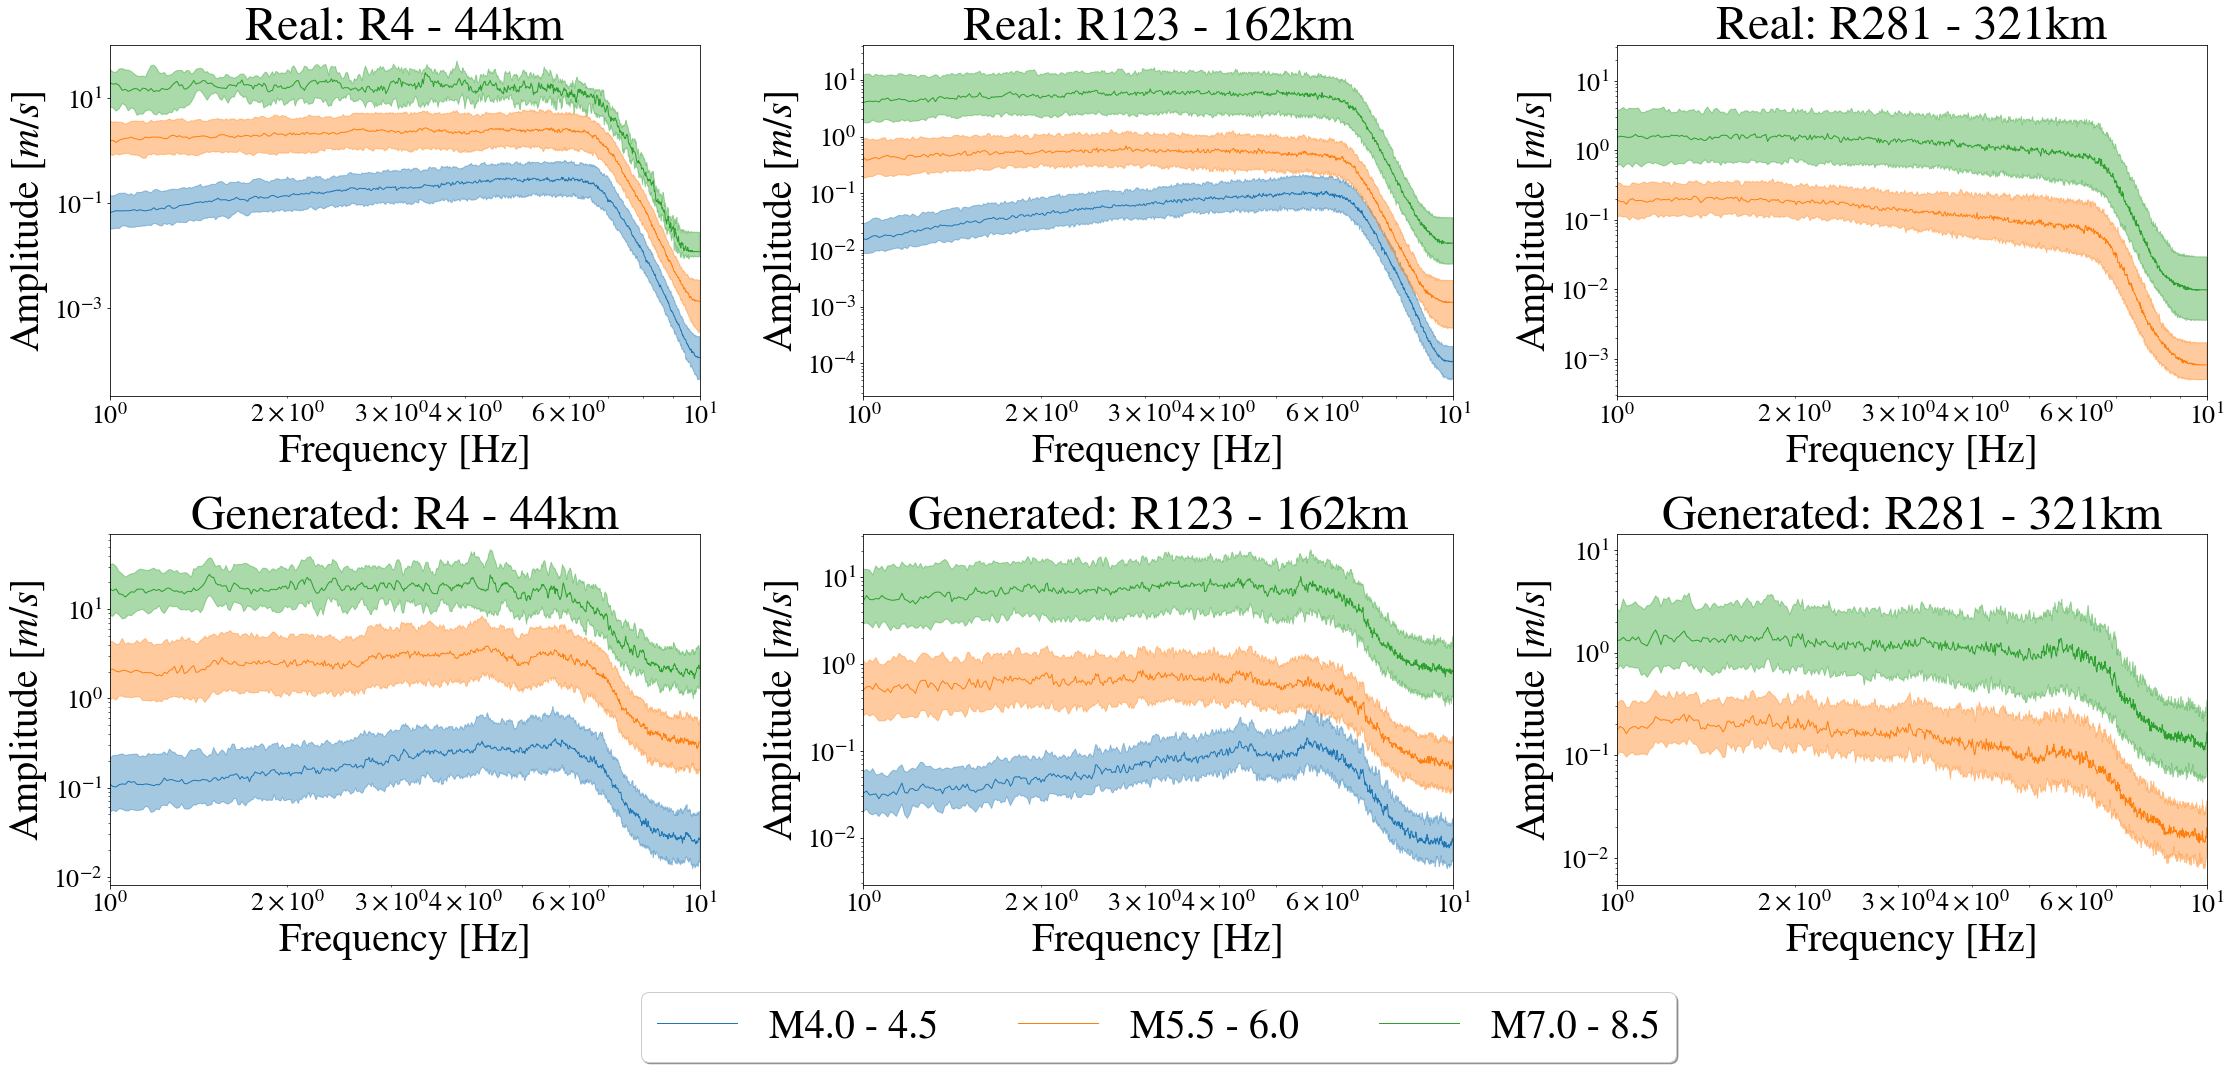

In [302]:
import SeisUtils; reload(SeisUtils); from SeisUtils import lineplot
set_plot_format((30, 24, 24)) # For Presentation
set_plot_format((40, 26, 26)) # For nuerips styling
horz_plots_n = 2 if not overlay_same_bins else max([len(b) for b in bins_ss])
fig, axs     = plt.subplots(horz_plots_n, len(bins_ss), figsize = (32, 16))
freq_list    = np.fft.fftfreq(n_time_steps, d = 1 / measure_rate)
quantiles    = [0.25, 0.5, 0.75]
x_label      = 'Frequency [Hz]'
y_label      = 'Amplitude [$m/s$]'
m_freq_steps = int(n_time_steps / 2)
for i, bins_s in enumerate(bins_ss):
   
    for j, bins in enumerate(bins_s):
        
        magn_label = 'M{:.1f} - {:.1f}'.format(*magn_bins[bins[meta_names.index('magn')]])
        dist_label = 'R{:.0f} - {:.0f}km'.format(*dist_bins[bins_s[0][0]])

        samp_label  = magn_label if not overlay_same_bins else 'Real' 
        gen_label   = magn_label if not overlay_same_bins else 'Fake'

        samp_title  = 'Real: '      + dist_label if not overlay_same_bins else (magn_label + ' ' + dist_label) if overlay_same_bins else dist_label
        gen_title   = 'Generated: ' + dist_label if not overlay_same_bins else None
        
        samp_quantiles = [np.quantile(np.linalg.norm(samp_fft_d[bins][:, 0:m_freq_steps, :], axis = 2), q, axis = 0) for q in quantiles]
        gen_quantiles  = [np.quantile(np.linalg.norm(gen_fft_d [bins][:, 0:m_freq_steps, :], axis = 2), q, axis = 0) for q in quantiles]

        if not overlay_same_bins:
            color_real = color_fake = colors_d[bins[meta_names.index('magn')]]
        else:
            color_real = colors_s[2]
            color_fake = colors_s[1]

        pltlabels_real_d = {'x_label' : x_label, 'y_label' : y_label, 'color' : color_real}
        pltlabels_fake_d = {'x_label' : x_label, 'y_label' : y_label, 'color' : color_fake}

        ax = axs[i    ] if len(bins_ss) == 1 else axs[0, i] 
               
        lineplot(*gen_quantiles , loglog = True, x_list = freq_list[0:m_freq_steps], xlim = [1, 10], ylim = [1, 18] if normalize else None, ax = get_ax(axs, i, j, real = False), title = gen_title , line_lable = gen_label , **pltlabels_fake_d)
        lineplot(*samp_quantiles, loglog = True, x_list = freq_list[0:m_freq_steps], xlim = [1, 10], ylim = [1, 18] if normalize else None, ax = get_ax(axs, i, j, real = True ), title = samp_title, line_lable = samp_label, **pltlabels_real_d)

        
fig.tight_layout() 

# Put legend underneath.
if True: put_legend_underneath_axes(fig, axs)

global_step = gm.sess.run(gm.global_step)
print('Saving image at global step:', global_step)
fig.savefig(os.path.join(project_dir, '{:08d}_realFake_magn_freqs.png'.format(global_step)))
if True: fig.savefig(os.path.join(project_dir, '{:08d}_realFake_magn_freqs.svg'.format(global_step)), format = 'svg')

Saving image at global step: 87348


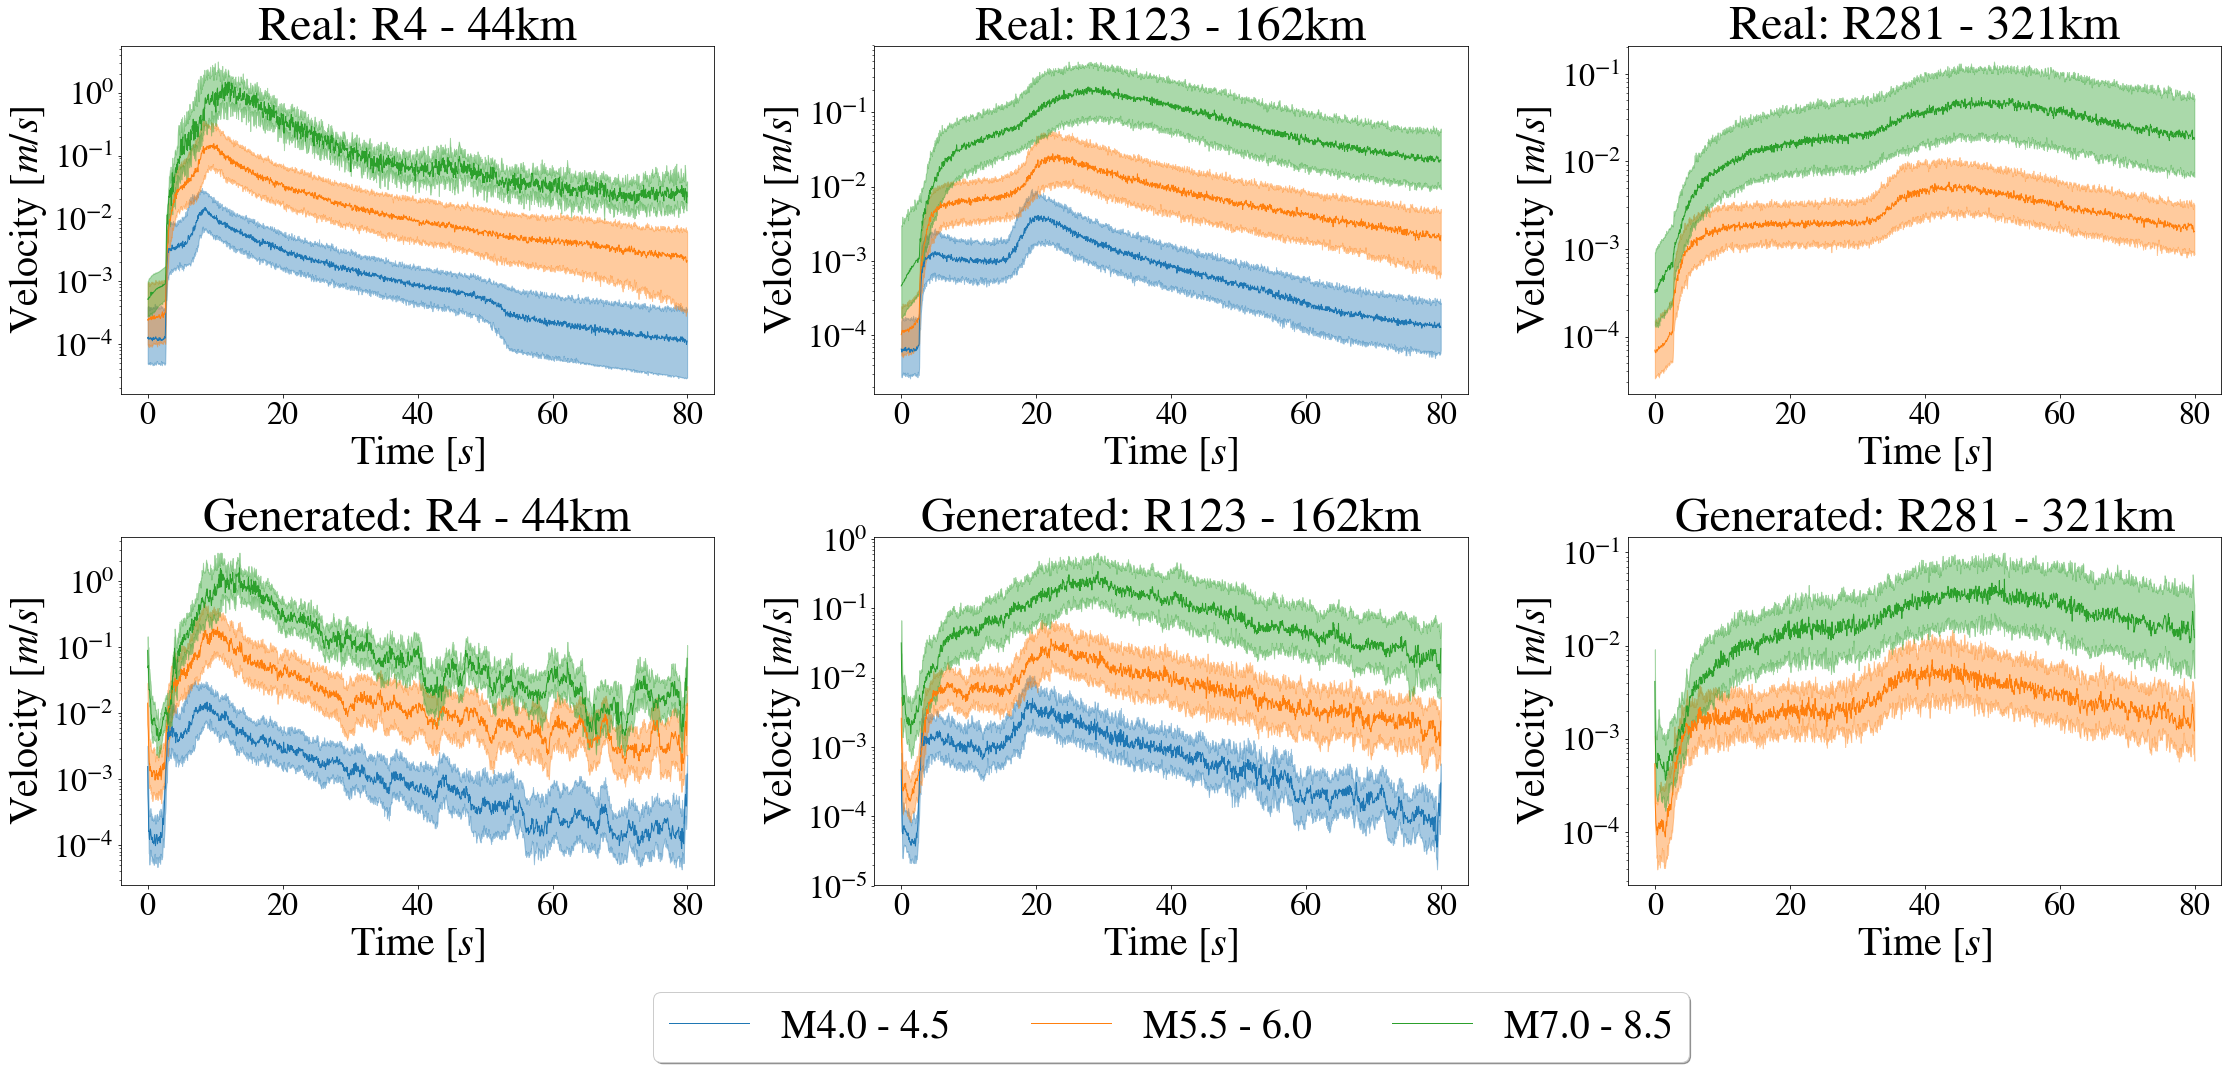

In [303]:
import SeisUtils; reload(SeisUtils); from SeisUtils import lineplot
set_plot_format((30, 24, 24)) # For Presentation
set_plot_format((40, 32, 32)) # For nuerips styling
# fig, axs    = plt.subplots(2, len(bins_ss), figsize = (32, 16))
horz_plots_n = 2 if not overlay_same_bins else max([len(b) for b in bins_ss])
fig, axs     = plt.subplots(horz_plots_n, len(bins_ss), figsize = (32, 16))

x_list      = np.arange(n_time_steps) / measure_rate
x_label     = 'Time [$s$]'
y_label     = 'Velocity [$m/s$]'
quantiles  = [0.25, 0.5, 0.75]

for i, bins_s in enumerate(bins_ss):
   
    for j, bins in enumerate(bins_s):

        magn_label = 'M{:.1f} - {:.1f}'.format(*magn_bins[bins[meta_names.index('magn')]])
        dist_label = 'R{:.0f} - {:.0f}km'.format(*dist_bins[bins_s[0][0]])

        samp_label  = magn_label if not overlay_same_bins else 'Real' 
        gen_label   = magn_label if not overlay_same_bins else 'Fake'

        samp_title  = 'Real: '      + dist_label if not overlay_same_bins else (magn_label + ' ' + dist_label) if overlay_same_bins else dist_label
        gen_title   = 'Generated: ' + dist_label if not overlay_same_bins else None

        samp_quantiles = [np.quantile(np.linalg.norm(samp_bin_d[bins][:, 0:n_time_steps, :], axis = 2), q, axis = 0) for q in quantiles]
        gen_quantiles  = [np.quantile(np.linalg.norm(gen_bin_d [bins][:, 0:n_time_steps, :], axis = 2), q, axis = 0) for q in quantiles]
    
        if not overlay_same_bins:
            color_real = color_fake = colors_d[bins[meta_names.index('magn')]]
        else:
            color_real = colors_s[2]
            color_fake = colors_s[1]

        pltlabels_real_d = {'x_label' : x_label, 'y_label' : y_label, 'color' : color_real}
        pltlabels_fake_d = {'x_label' : x_label, 'y_label' : y_label, 'color' : color_fake}

        ax = axs[i    ] if len(bins_ss) == 1 else axs[0, i] 

        lineplot(*gen_quantiles , yscale = 'log', x_list = x_list, ylim = [0.0001, 1] if normalize else None, ax = get_ax(axs, i, j, real = False), title = gen_title , line_lable = gen_label , **pltlabels_fake_d) 
        lineplot(*samp_quantiles, yscale = 'log', x_list = x_list, ylim = [0.0001, 1] if normalize else None, ax = get_ax(axs, i, j, real = True ), title = samp_title, line_lable = samp_label, **pltlabels_real_d) 

fig.tight_layout()

# Put legend underneath axes.
if True: put_legend_underneath_axes(fig, axs) 
 
global_step = gm.sess.run(gm.global_step)
print('Saving image at global step:', global_step)
fig.savefig(os.path.join(project_dir, '{:08d}_realFake_magn_ranges.png'.format(global_step)))
if True: fig.savefig(os.path.join(project_dir, '{:08d}_realFake_magn_ranges.svg'.format(global_step)), format = 'svg')

# Compute T-test Stats in comparison of means

In [238]:
from scipy.stats import ttest_ind

0.9987136388877993 0.3764194627485364
0.9996910440866198 0.3180536815255183
0.999936526484587 0.3530883546103481
0.9985069615621358 0.3077443271715143
0.9994368218840539 0.40614126298157055
0.9986270915469613 0.3570388067415226
0.9999974442669594 0.39318483727627473
0.9421060735992905 0.023381088202186272
Saving image at global step: 87348


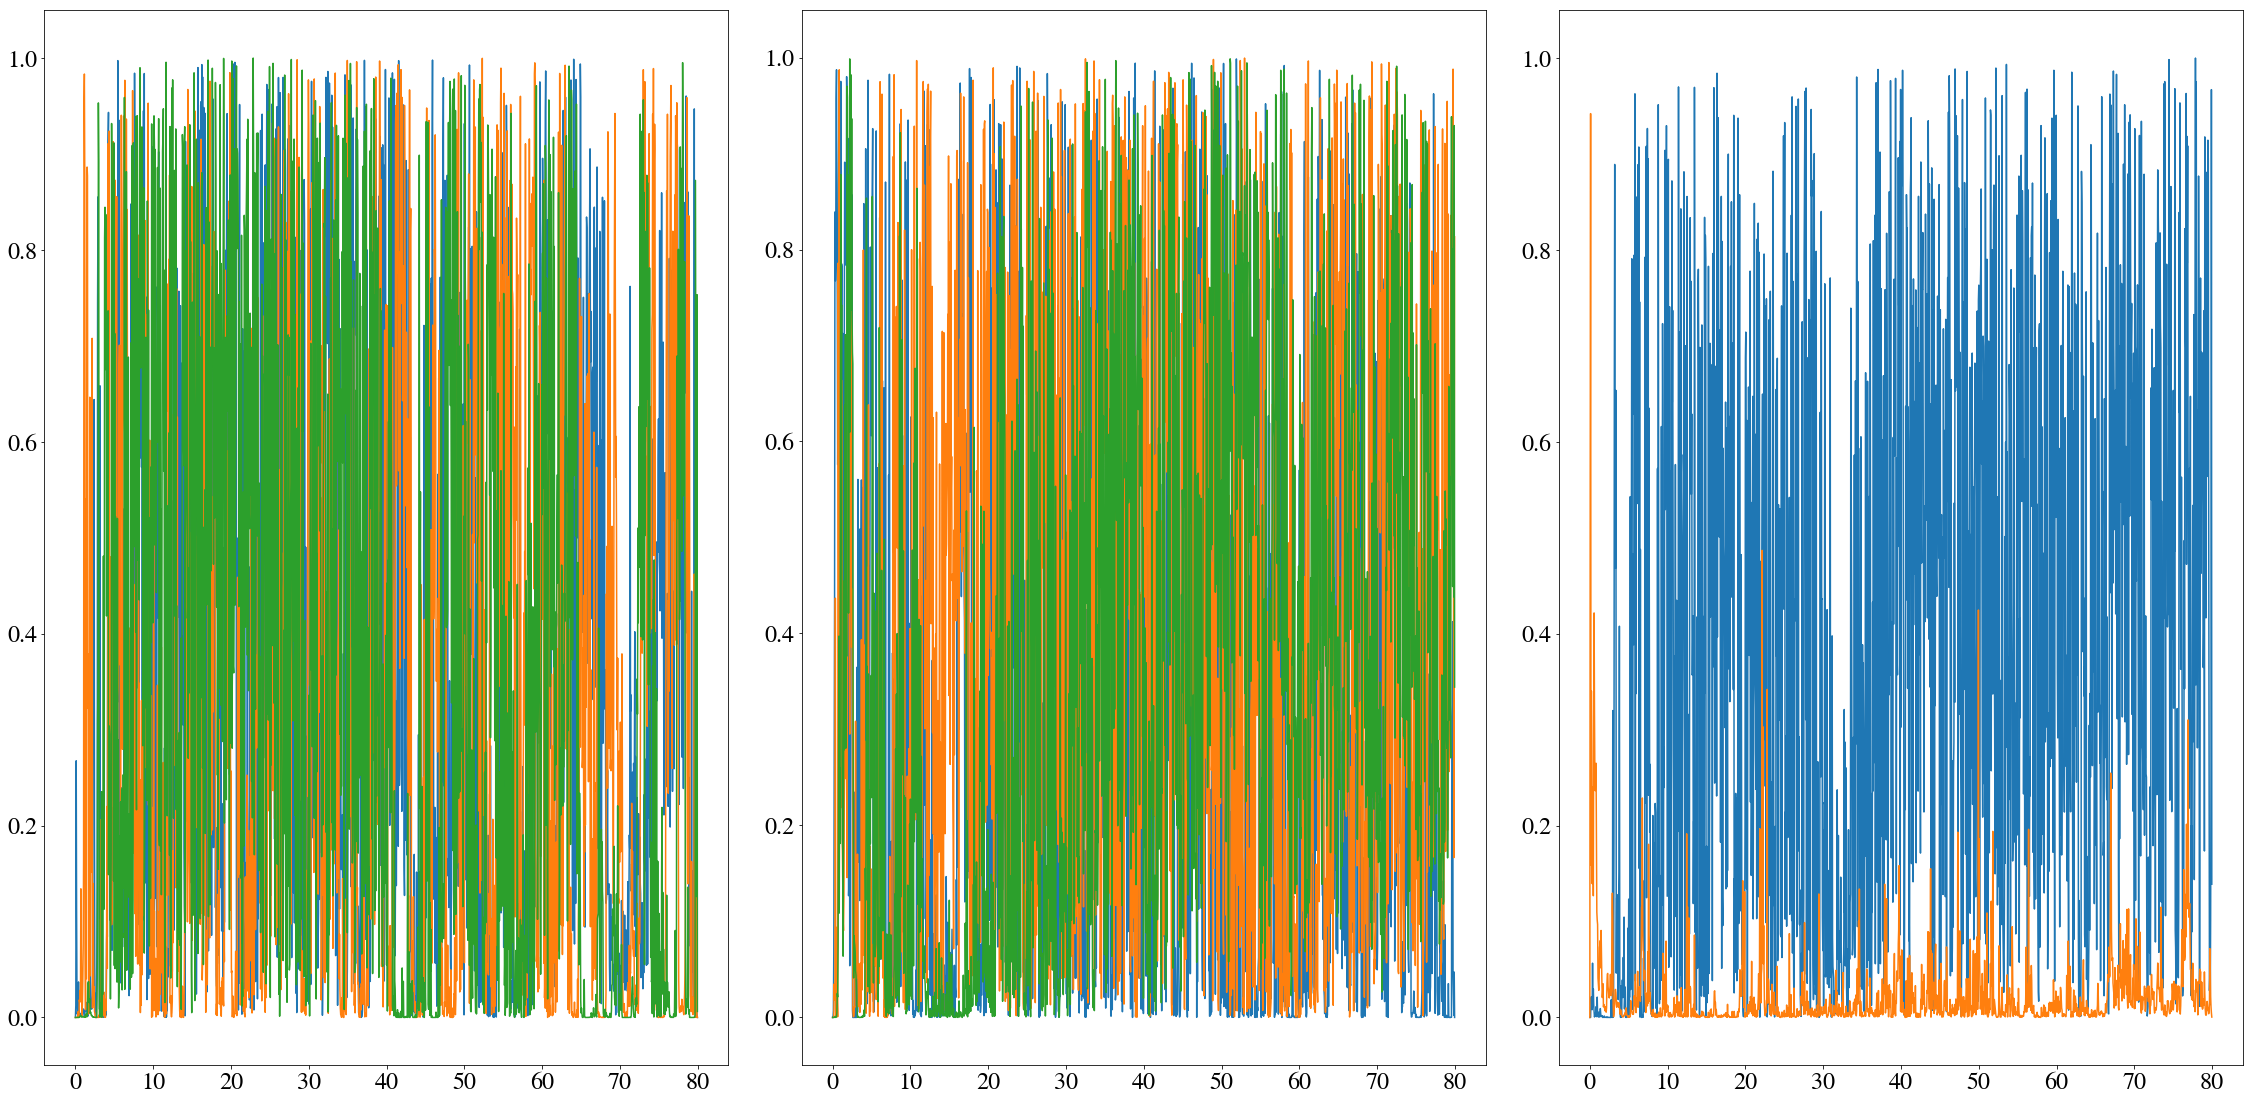

In [251]:
import SeisUtils; reload(SeisUtils); from SeisUtils import lineplot
set_plot_format((30, 24, 24))
horz_plots_n = 2 if not overlay_same_bins else max([len(b) for b in bins_ss])
fig, axs     = plt.subplots(1, len(bins_ss), figsize = (32, 16))

x_list      = np.arange(n_time_steps) / measure_rate
x_label     = 'Time [$s$]'
y_label     = 'Velocity [$m/s$]'

for i, bins_s in enumerate(bins_ss):
   
    for j, bins in enumerate(bins_s):

#         magn_label = 'M{:.1f} - {:.1f}'.format(*magn_bins[bins[meta_names.index('magn')]])
#         dist_label = 'R{:.0f} - {:.0f}km'.format(*dist_bins[bins_s[0][0]])

#         samp_label  = magn_label if not overlay_same_bins else 'Real' 
#         gen_label   = magn_label if not overlay_same_bins else 'Fake'

#         samp_title  = 'Real: '      + dist_label if not overlay_same_bins else (magn_label + ' ' + dist_label) if overlay_same_bins else dist_label
#         gen_title   = 'Generated: ' + dist_label if not overlay_same_bins else None

        samp_quantiles = np.linalg.norm(samp_bin_d[bins][:, 0:n_time_steps, :], axis = 2)
        gen_quantiles  = np.linalg.norm(gen_bin_d [bins][:, 0:n_time_steps, :], axis = 2)
        
        tt = ttest_ind(samp_quantiles, gen_quantiles)
        
        print(np.max(tt.pvalue), np.mean(tt.pvalue))
        
        if not overlay_same_bins:
            color_real = color_fake = colors_d[bins[meta_names.index('magn')]]
        else:
            color_real = colors_s[2]
            color_fake = colors_s[1]

        pltlabels_real_d = {'x_label' : x_label, 'y_label' : y_label, 'color' : color_real}
        pltlabels_fake_d = {'x_label' : x_label, 'y_label' : y_label, 'color' : color_fake}

#         ax = get_ax(axs, i, j, real = False)
        axs[i].plot(x_list, tt.pvalue)
        
#         plot_wforms(samp_quantiles)

#         lineplot(*gen_quantiles , yscale = 'log', x_list = x_list, ylim = [0.0001, 1] if normalize else None, ax = get_ax(axs, i, j, real = False), title = gen_title , line_lable = gen_label , **pltlabels_fake_d) 
#         lineplot(*samp_quantiles, yscale = 'log', x_list = x_list, ylim = [0.0001, 1] if normalize else None, ax = get_ax(axs, i, j, real = True ), title = samp_title, line_lable = samp_label, **pltlabels_real_d) 
   
fig.tight_layout() 
global_step = gm.sess.run(gm.global_step)
print('Saving image at global step:', global_step)
fig.savefig(os.path.join(project_dir, '{:08d}_ttest_means.png'.format(global_step)))
if True: fig.savefig(os.path.join(project_dir, '{:08d}_ttest_means.svg'.format(global_step)), format = 'svg')

# Save Fake Waveforms

In [226]:
gen_file.close()

In [227]:
import h5py
import numpy.matlib as matlib

data_path = 'wformMat_generated.h5'
print('Opening file: ...')
print('   data_path (to read ):', data_path)

# Create h5 file to save results.
gen_file = h5py.File(data_path, 'w')

# Define number of samples per bin.
N = 256 

# Define total number of bins.
B = len(all_bins)

# Create dataset to store generated waveforms.
gen_file.create_dataset("wforms", (3, n_time_steps, N * B), chunks = (3, n_time_steps, N))

# Create dataset in h5 file to store corresponding bins.
for i, m in enumerate(meta_names):
    gen_file.create_dataset(m, (2, N * B), dtype = gm.bins[1].dtype) # We'll save both the lower and upper edges of each bin for a given sample; hence the (2, ...)


# Enumerate over all possible bins to generate samples from each bin. 
#     Note: Some of them won't make sense to sample as they may not be 
#           represented in the training dataset or even the full dataset.
#           Nonetheless, the generated samples may still look reasonable.
#
for i, b in enumerate(all_bins):
    
    # Sample the waveforms.
    predgen = gen_wforms(bins = b, N = N)
    predgen = predgen.transpose((2, 1, 0))
    
    # Save them to the file.
    idx1 = (N * i)
    idx2 = (N * (i + 1))
    gen_file['wforms'][..., idx1:idx2] = predgen
    
    for j, m in enumerate(meta_names):
        gen_file[m][..., idx1:idx2] = matlib.repmat(bin_edges[j][b[j]], N, 1).transpose()
        
# Close the file.
gen_file.close()

Opening file: ...
   data_path (to read ): wformMat_generated.h5


In [60]:
# S = gen_fft_d[bins_list[0]].shape[0]
# ex_real = np.zeros((1, S, len(bins_list)))
# for i in range(len(bins_list)):
#     ex_real[..., i] = samp_fft_d[bins_list[i]][..., 0]

# ex_fake = np.zeros((1, S, len(bins_list)))
# for i in range(len(bins_list)):
#     ex_fake[..., i] = gen_fft_d[bins_list[i]][0, ...]

# examples = np.vstack([ex_real, ex_fake])
# examples.shape

# fig, axs = plt.subplots(1, 1)
# axs.hist(examples[1, :, 0])
# [img.set_facecolor(plt.rcParams['axes.prop_cycle'].by_key()['color'][3]) for img in axs.get_images()]
# axs.set_facecolor(plt.rcParams['axes.prop_cycle'].by_key()['color'][3])

Saving image at global step: 150600


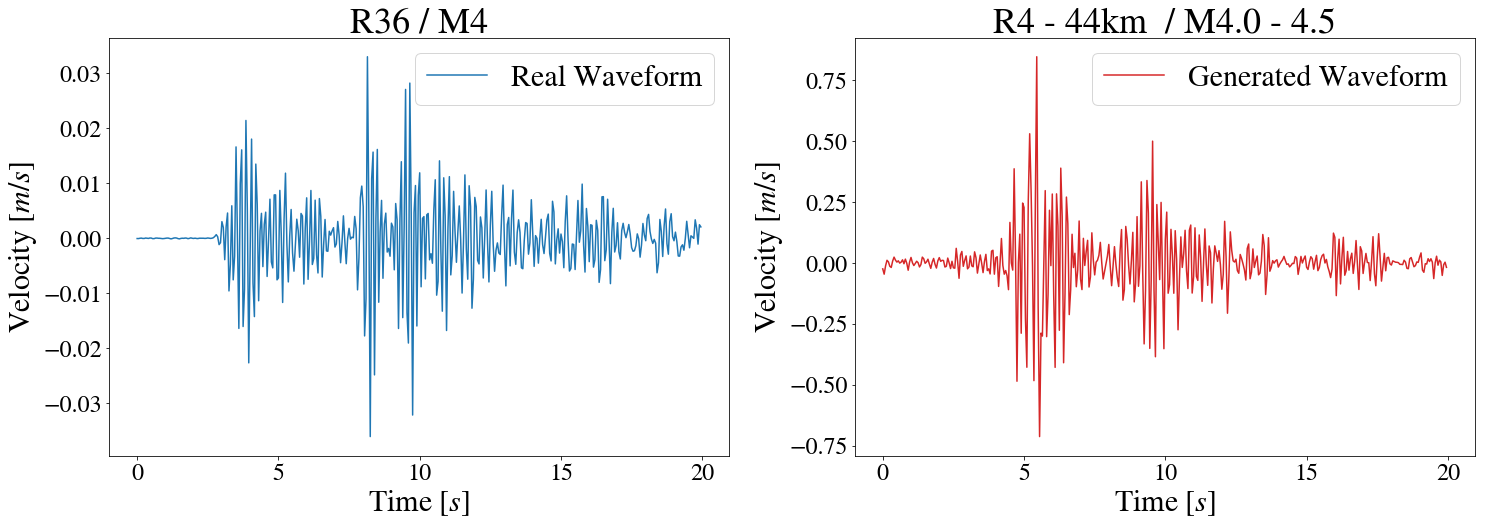

In [61]:
import SeisUtils; reload(SeisUtils); from SeisUtils import lineplot
set_plot_format('1by2')
fig, axs    = plt.subplots(1,  2, figsize = (21.33, 8))

axs[0].plot(
    x_values, 
    examples[:, :, 0].transpose()[:, 0],
)
axs[1].plot(
    x_values, 
    examples[:, :, 0].transpose()[:, 1],
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3],
)

# Plot Reals 
for j in range(2):
    axs[j].set_xlabel('Time [$s$]')
    axs[j].set_ylabel('Velocity [$m/s$]')
    if normalize: axs[j].set_ylim([-1, 1])
axs[0].set_title(test_meta_values[0])
axs[1].legend(['Generated Waveform'], loc = 'upper right')
axs[1].set_title(pred_meta_values[0])
axs[0].legend(['Real Waveform'], loc = 'upper right')

        
fig.tight_layout() 
global_step = gm.sess.run(gm.global_step)
print('Saving image at global step:', global_step)
fig.savefig(os.path.join(project_dir, '{:08d}_OneRealFake_example_wforms.png'.format(global_step)))
if True: fig.savefig(os.path.join(project_dir, '{:08d}_OneRealFake_example_wforms.svg'.format(global_step)), format = 'svg')

In [ ]:
import SeisUtils; reload(SeisUtils); from SeisUtils import lineplot
set_plot_format((50, 40, 40))
fig, axs    = plt.subplots(1,  1, figsize = (21.33, 16))
freq_list   = np.fft.fftfreq(400, d = 1 / gm.config.get('measure_rate', 100))
quantiles   = [0.25, 0.5, 0.75]
x_label     = 'Frequency [Hz]'
y_label     = 'Amplitude [$m/s$]'
bins_s = bins_ss[0]
   
for j, bins in enumerate(bins_s):

    line_label  = 'M{:.1f} - {:.1f}'.format(*magn_bins[bins[meta_names.index('magn')]])

    samp_title  = 'R{:.0f} - {:.0f}km'.format(*dist_bins[bins_s[0][0]])

    color       = colors_d[bins[meta_names.index('magn')]]

    samp_quantiles = [np.quantile(np.linalg.norm(samp_fft_d[bins][:, 0:200, :], axis = 2), q, axis = 0) for q in quantiles]

    pltlabels_d    = {'x_label' : x_label, 'y_label' : y_label, 'color' : color}

    lineplot(*samp_quantiles, loglog = True, x_list = freq_list[0:200], xlim = [1, 10], ylim = [1, 18] if normalize else None, ax = axs, title = samp_title, line_lable = line_label, **pltlabels_d)

# axs.set_xticklabels(['10^4', '2', '3', '4', '6', '10^1', '3'])
fig.tight_layout() 
global_step = gm.sess.run(gm.global_step)
print('Saving image at global step:', global_step)
fig.savefig(os.path.join(project_dir, '{:08d}_OneReal_magn_freqs.png'.format(global_step)))
if True: fig.savefig(os.path.join(project_dir, '{:08d}_OneReal_magn_freqs.svg'.format(global_step)), format = 'svg')

In [ ]:
import SeisUtils; reload(SeisUtils); from SeisUtils import lineplot
set_plot_format('1by2')
fig, axs    = plt.subplots(1,  2, figsize = (21.33, 8))
x_list      = np.arange(400) / gm.config.get('measure_rate', None)
x_label     = 'Time [$s$]'
y_label     = 'Velocity [$m/s$]'
quantiles  = [0.25, 0.5, 0.75]

bins_s = bins_ss[0]
   
for j, bins in enumerate(bins_s):

    line_label  = 'M{:.1f} - {:.1f}'.format(*magn_bins[bins[1]])

    samp_title  = 'Real: ' + 'R{:.0f} - {:.0f}km'.format(*dist_bins[bins_s[0][0]])
    gen_title   = 'Generated: ' + 'R{:.0f} - {:.0f}km'.format(*dist_bins[bins_s[0][0]])

    color       = colors_d[bins[1]]

    samp_quantiles = [np.quantile(np.linalg.norm(samp_bin_d[bins], axis = 2), q, axis = 0) for q in quantiles]
    gen_quantiles  = [np.quantile(np.linalg.norm(gen_bin_d [bins], axis = 2), q, axis = 0) for q in quantiles]


    pltlabels_d    = {'x_label' : x_label, 'y_label' : y_label, 'color' : color}

    lineplot(*samp_quantiles, yscale = 'log', x_list = x_list, ylim = [0.0001, 1] if normalize else None, ax = axs[0], title = samp_title, line_lable = line_label, **pltlabels_d) 
    lineplot(*gen_quantiles , yscale = 'log', x_list = x_list, ylim = [0.0001, 1] if normalize else None, ax = axs[1], title = gen_title , line_lable = line_label, **pltlabels_d) 

fig.tight_layout() 
global_step = gm.sess.run(gm.global_step)
print('Saving image at global step:', global_step)
fig.savefig(os.path.join(project_dir, '{:08d}_OneRealFake_magn_ranges.png'.format(global_step)))

In [ ]:
import SeisUtils; reload(SeisUtils); from SeisUtils import lineplot
set_plot_format((50, 40, 40))
fig, axs    = plt.subplots(1,  1, figsize = (21.33, 16))
x_list      = np.arange(400) / gm.config.get('measure_rate', None)
x_label     = 'Time [$s$]'
y_label     = 'Velocity [$m/s$]'
quantiles  = [0.25, 0.5, 0.75]

bins_s = bins_ss[0]
   
for j, bins in enumerate(bins_s):

    line_label  = 'M{:.1f} - {:.1f}'.format(*magn_bins[bins[1]])

    samp_title  = 'R{:.0f} - {:.0f}km'.format(*dist_bins[bins_s[0][0]])
    gen_title   = 'R{:.0f} - {:.0f}km'.format(*dist_bins[bins_s[0][0]])

    color       = colors_d[bins[1]]

    samp_quantiles = [np.quantile(np.linalg.norm(samp_bin_d[bins], axis = 2), q, axis = 0) for q in quantiles]
    gen_quantiles  = [np.quantile(np.linalg.norm(gen_bin_d [bins], axis = 2), q, axis = 0) for q in quantiles]


    pltlabels_d    = {'x_label' : x_label, 'y_label' : y_label, 'color' : color}

    lineplot(*samp_quantiles, yscale = 'log', x_list = x_list, ylim = [0.0001, 1] if normalize else None, ax = axs, title = samp_title, line_lable = line_label, **pltlabels_d) 

fig.tight_layout() 
global_step = gm.sess.run(gm.global_step)
print('Saving image at global step:', global_step)
fig.savefig(os.path.join(project_dir, '{:08d}_OneReal_magn_ranges.png'.format(global_step)))